In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from navigation_game import NavigableNetwork
import scipy
import numpy as np
from vizman import viz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy.stats import ks_2samp
from scipy.spatial.distance import pdist, squareform

In [3]:
def evaluator(synthetic, empirical, euclidean_distance):
    degrees_synthetic = np.sum(synthetic, axis=0)
    degrees_empirical = np.sum(empirical, axis=0)
    ks_degree = ks_2samp(degrees_synthetic, degrees_empirical)
    
    clustering_synthetic = nx.clustering(nx.from_numpy_array(synthetic))
    clustering_empirical = nx.clustering(nx.from_numpy_array(empirical))
    ks_clustering = ks_2samp(list(clustering_synthetic.values()), list(clustering_empirical.values()))
    
    betweenness_synthetic = nx.betweenness_centrality(nx.from_numpy_array(synthetic))
    betweenness_empirical = nx.betweenness_centrality(nx.from_numpy_array(empirical))
    ks_betweenness = ks_2samp(list(betweenness_synthetic.values()), list(betweenness_empirical.values()))
    
    distance_synthetic = euclidean_distance[np.triu(synthetic, 1) > 0]
    distance_empirical = euclidean_distance[np.triu(empirical, 1) > 0]
    ks_distance = ks_2samp(distance_synthetic, distance_empirical)
    
    return np.max([ks_degree[0], ks_clustering[0], ks_betweenness[0], ks_distance[0]])



In [4]:
viz.set_visual_style()
default_sizes = viz.load_data_from_json("sizes.json")
default_colors = viz.load_data_from_json("colors.json")
default_cmaps = viz.give_colormaps()

In [5]:
default_colors

{'neutrals': {'BONE_WHITE': '#FFFCF2',
  'ALL_WHITE': '#FFFFFF',
  'GRAY': '#b8b8b8',
  'OLIVE_GRAY': '#6A7870',
  'HALF_BLACK': '#232324'},
 'colds': {'INK_BLUE': '#0F14F7',
  'NIGHT_BLUE': '#394D73',
  'DEEP_BLUE': '#006685',
  'LAKE_BLUE': '#3FA5C4',
  'TEAL': '#44cfcf'},
 'warms': {'SAND': '#E1C5A2',
  'YELLOW': '#E6B213',
  'ORANGE': '#F99465',
  'LECKER_RED': '#E84653',
  'DEEP_RED': '#BF003F'},
 'purples': {'PINK': '#EFBBD3',
  'PURPLE': '#A6587C',
  'PURPLER': '#591154',
  'PURPLEST': '#260126'},
 'greens': {'GRASS_GREEN': '#5DC400',
  'SLOW_GREEN': '#a1d4ca',
  'JUST_GREEN': '#4BAE6A',
  'LUXUARY_GREEN': '#275036',
  'ULTRA_GREEN': '#52FF94'}}

In [6]:
default_sizes

{'small': [5, 3],
 'half_column': [9, 5],
 'wide': [18, 9],
 'half_page': [18, 12],
 'full_page': [18, 16]}

In [7]:
default_cmaps

{'db_bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x1086ed6d0>,
 'nb_bw_dr': <matplotlib.colors.LinearSegmentedColormap at 0x15e9573d0>,
 'sg_bw_pi': <matplotlib.colors.LinearSegmentedColormap at 0x15ed36a10>,
 'bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x15ed36790>,
 'bw_db': <matplotlib.colors.LinearSegmentedColormap at 0x15ed3e790>,
 'bw_hb': <matplotlib.colors.LinearSegmentedColormap at 0x1595ede90>}

In [8]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


<Axes: >

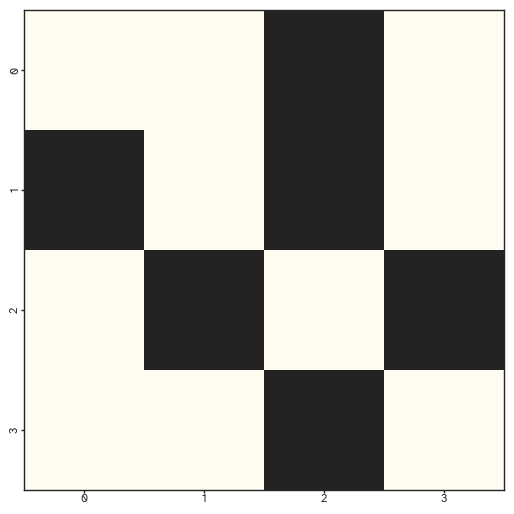

In [9]:
viz.plot_matrix(equilibrium, sns_kwargs={"cmap":default_cmaps["bw_hb"]})

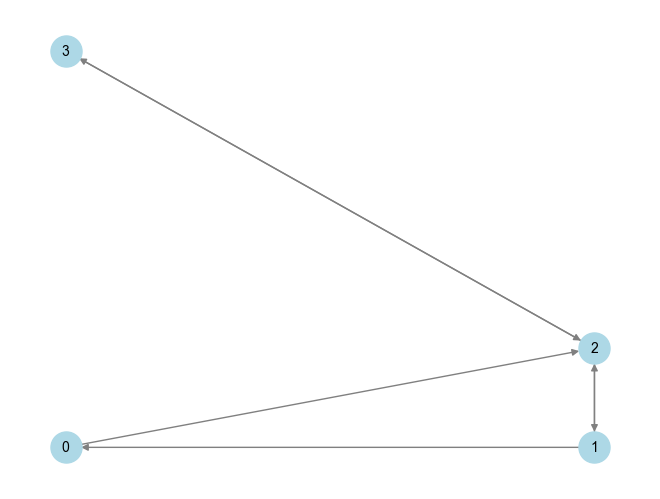

In [10]:

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [11]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

In [12]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()

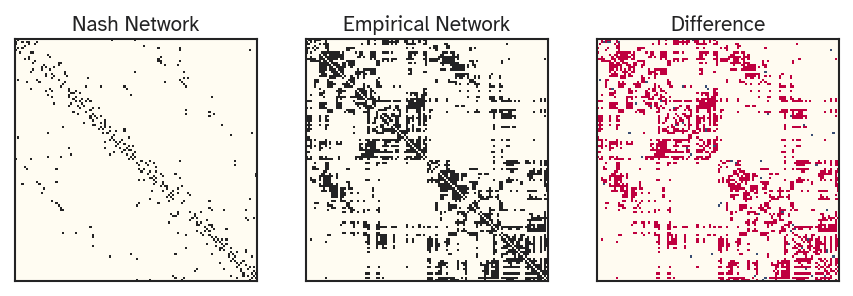

In [13]:
fig, axes = plt.subplot_mosaic([["A", "B","C"]], figsize=viz.cm_to_inch(default_sizes['half_page']), dpi=150)
viz.plot_matrix(nash_network.astype(int), axis=axes["A"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int), axis=axes["B"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int)-nash_network.astype(int), axis=axes["C"], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                                                               "xticklabels":False, "yticklabels":False})
axes["A"].set_title("Nash Network")
axes["B"].set_title("Empirical Network")
axes["C"].set_title("Difference");

In [14]:
from navigation_game import NetworkParameters, DevelopingNetwork, SimulationMode
from tqdm import tqdm

# Create parameters
# params = NetworkParameters(
#     alpha=1.0,
#     beta_infinity=1.0,
#     tau_beta=50.0,
#     t0=1.0,
#     tau_t=50.0,
#     connectivity_penalty=100.0,
#     n_flips_per_iteration=10,
#     seed=42
# )

fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=131,
    beta=0.12,
    temperature=0.0,
    connectivity_penalty=0.0
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=3000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)

Evaluating network evolution: 100%|██████████| 3000/3000 [02:14<00:00, 22.38it/s]


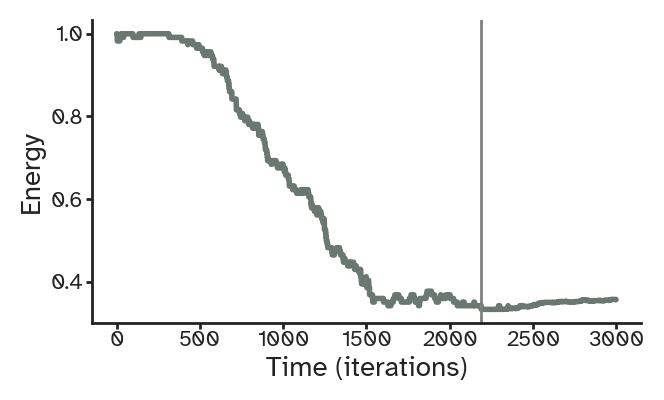

In [15]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
sns.despine()

Evaluating network evolution: 100%|██████████| 3000/3000 [00:33<00:00, 89.80it/s]


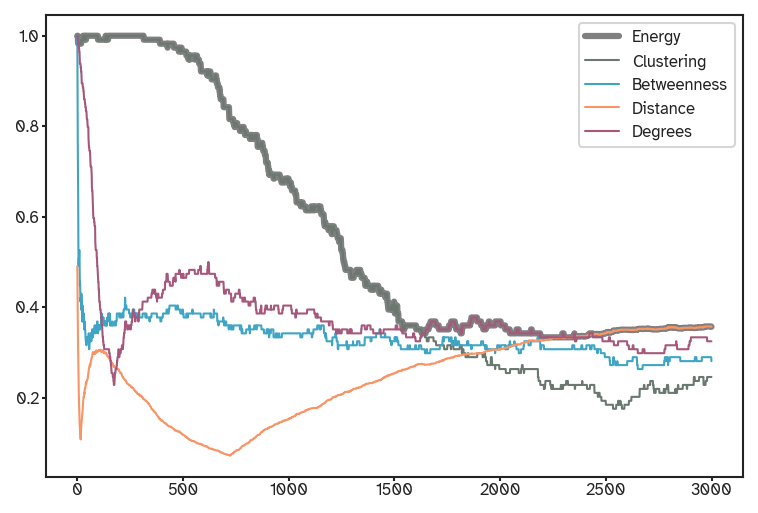

In [16]:
from utils import fast_evaluator
energy_vector = np.zeros(adjacency_history.shape[2])
clustering_vector = np.zeros(adjacency_history.shape[2])
betweenness_vector = np.zeros(adjacency_history.shape[2])
distance_vector = np.zeros(adjacency_history.shape[2])
degrees_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

plt.figure(figsize=(6, 4),dpi=150)
plt.plot(energy_vector,lw=3,label='Energy',color='gray')
plt.plot(clustering_vector,lw=1,label='Clustering')
plt.plot(betweenness_vector,lw=1,label='Betweenness')
plt.plot(distance_vector,lw=1,label='Distance')
plt.plot(degrees_vector,lw=1,label='Degrees')
plt.legend();

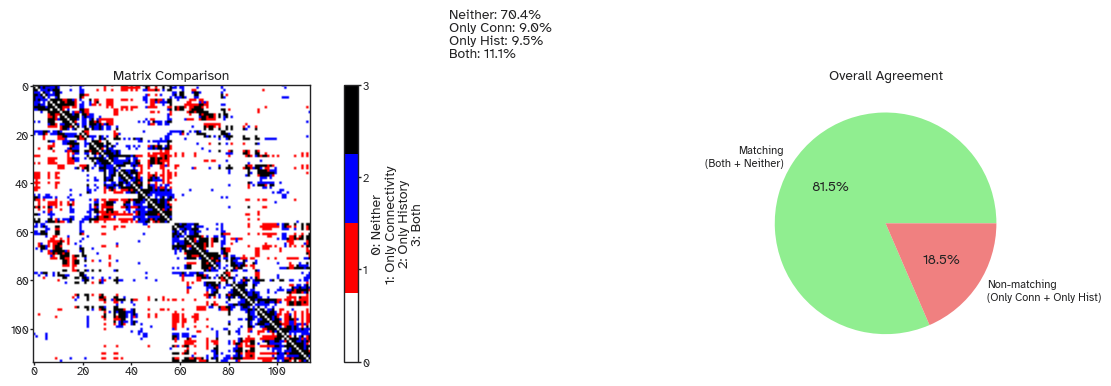

In [17]:
# Create a figure
plt.figure(figsize=(15, 4))

# Get the time point with minimum energy
min_energy_point = np.argmin(energy_vector)

# Create subplots
plt.subplot(121)
# Create a custom matrix where:
# 0: neither (white)
# 1: only connectivity (red)
# 2: only history (blue)
# 3: both (black)
comparison = connectivity.astype(int) + 2 * adjacency_history[:,:,min_energy_point].astype(int)
plt.imshow(comparison, cmap=plt.cm.colors.ListedColormap(['white', 'red', 'blue', 'black']))
plt.title('Matrix Comparison')
plt.colorbar(ticks=[0, 1, 2, 3], 
            label='0: Neither\n1: Only Connectivity\n2: Only History\n3: Both')

# Add percentage text
total = connectivity.shape[0] * connectivity.shape[1]
neither = np.sum(comparison == 0) / total * 100
only_conn = np.sum(comparison == 1) / total * 100
only_hist = np.sum(comparison == 2) / total * 100
both = np.sum(comparison == 3) / total * 100

plt.text(1.5, 1.1, f'Neither: {neither:.1f}%\nOnly Conn: {only_conn:.1f}%\n'
         f'Only Hist: {only_hist:.1f}%\nBoth: {both:.1f}%', 
         transform=plt.gca().transAxes)

# Add second subplot for overlap percentage
plt.subplot(122)
labels = ['Matching\n(Both + Neither)', 'Non-matching\n(Only Conn + Only Hist)']
values = [(both + neither), (only_conn + only_hist)]
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Overall Agreement')

plt.tight_layout()

Evaluating network evolution: 100%|██████████| 3000/3000 [00:03<00:00, 866.31it/s]


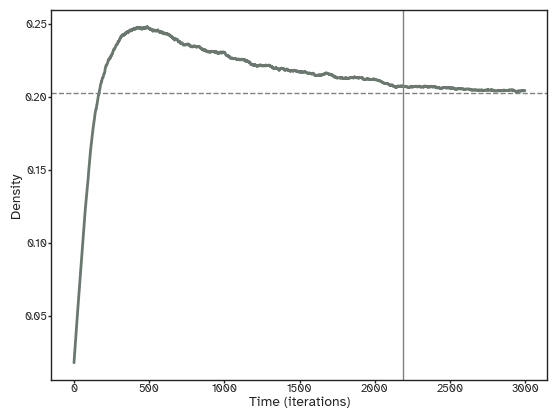

In [18]:
density = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(adjacency_history[:,:,t]))

plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(energy_vector), color='gray', linestyle='-')

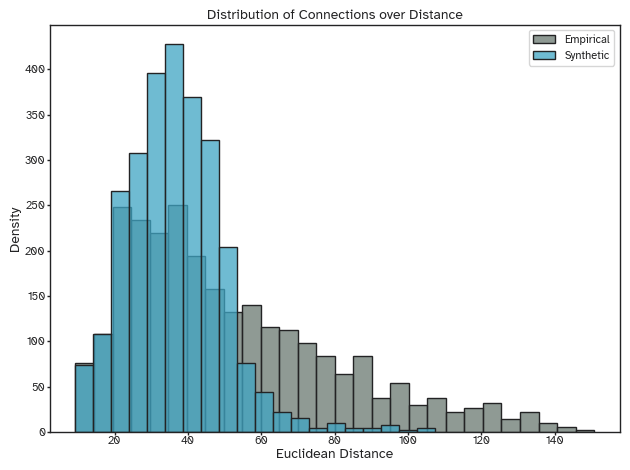

In [21]:
sns.histplot(euclidean_dis[connectivity],binwidth=5, label='Empirical')
what = adjacency_history[:,:,np.argmin(energy_vector)].astype(bool)
sns.histplot(euclidean_dis[what],binwidth=5, label= "Synthetic")

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

Evaluating network evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
Evaluating network evolution: 100%|██████████| 20000/20000 [00:41<00:00, 484.61it/s]


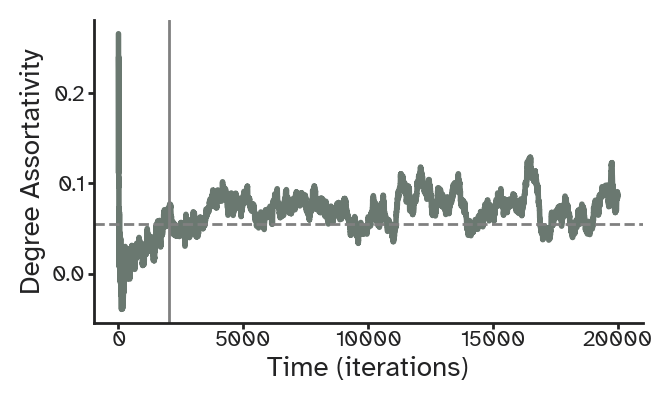

In [21]:
assortativity = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    assortativity[t] = nx.degree_assortativity_coefficient(nx.from_numpy_array(adjacency_history[:,:,t]))

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(assortativity,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Degree Assortativity")
empirical_assortativity = nx.degree_assortativity_coefficient(nx.from_numpy_array(connectivity))
plt.axhline(empirical_assortativity, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

Evaluating network evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 20000/20000 [00:24<00:00, 800.19it/s]


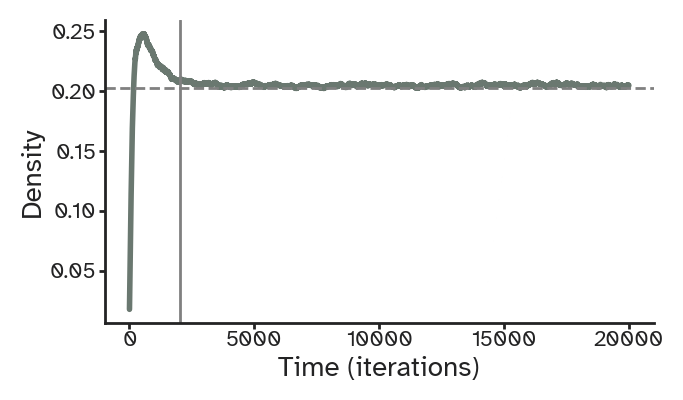

In [22]:
density = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(adjacency_history[:,:,t]))

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

Evaluating network evolution:   0%|          | 0/20000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 20000/20000 [01:20<00:00, 247.47it/s]


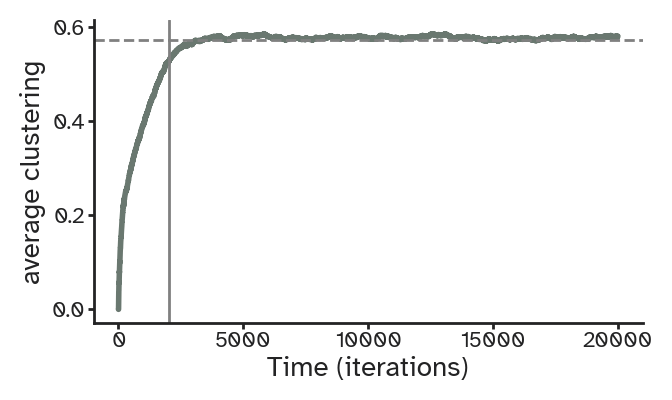

In [23]:
avg_clustering = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    avg_clustering[t] = nx.average_clustering(nx.from_numpy_array(adjacency_history[:,:,t]))
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(avg_clustering,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("average clustering")
empirical_average_clustering = nx.average_clustering(nx.from_numpy_array(connectivity))
plt.axhline(empirical_average_clustering, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

In [24]:
avg_spl = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    avg_spl[t] = nx.average_shortest_path_length(nx.from_numpy_array(adjacency_history[:,:,t]))

Evaluating network evolution: 100%|██████████| 20000/20000 [01:25<00:00, 233.54it/s]


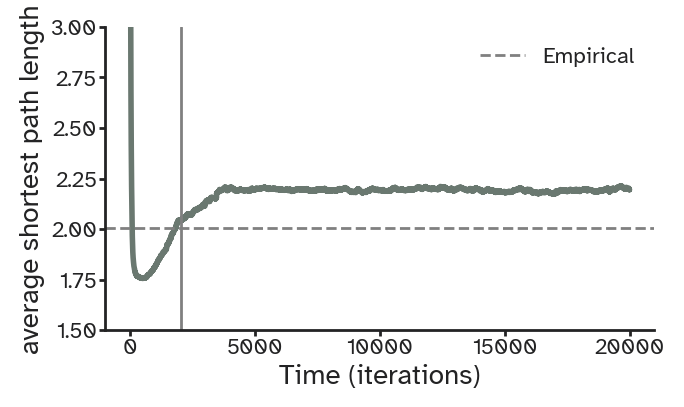

In [25]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(avg_spl,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("average shortest path length")
empirical_avg_spl = nx.average_shortest_path_length(nx.from_numpy_array(connectivity))
plt.axhline(empirical_avg_spl, color='gray', linestyle='--', label="Empirical")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

plt.ylim(1.5, 3)
plt.legend(frameon=False)

sns.despine()

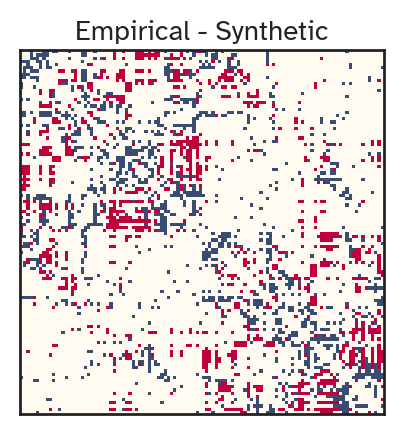

In [124]:
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [26]:
from scipy.stats import spearmanr

In [27]:
degree_correlation = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    degree_correlation[t] = np.mean(np.array([spearmanr(adjacency_history[i,:,t], connectivity[i,:])[0] for i in range(adjacency_history.shape[0])]))

Evaluating network evolution: 100%|██████████| 20000/20000 [02:42<00:00, 122.99it/s]


In [28]:
all_connectomes = scipy.io.loadmat(
    "datasets/Individual_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)['connMatrices']['SC'][res_parcellation].astype(bool)

In [29]:
all_connectomes.shape

(114, 114, 70)

Evaluating intersubject correlation:   0%|          | 0/70 [00:00<?, ?it/s]

/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Evaluating intersubject correlation: 100%|██████████| 70/70 [00:00<00:00, 122.11it/s]


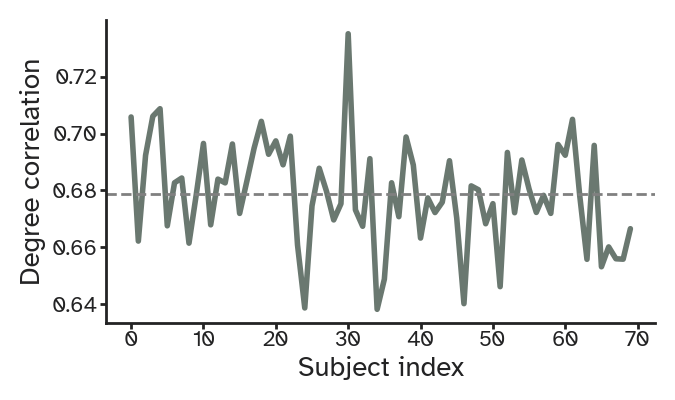

In [30]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
intersubject_correlation = np.zeros(all_connectomes.shape[2])
for i in tqdm(range(all_connectomes.shape[2]), desc="Evaluating intersubject correlation"):
    correlations = np.array([spearmanr(all_connectomes[k,:,i], connectivity[k,:])[0] for k in range(all_connectomes.shape[0])])
    intersubject_correlation[i] = np.nanmean(correlations)
plt.plot(intersubject_correlation,lw=2)
plt.axhline(np.mean(intersubject_correlation), color='gray', linestyle='--')
plt.xlabel("Subject index")
plt.ylabel("Degree correlation")
sns.despine()

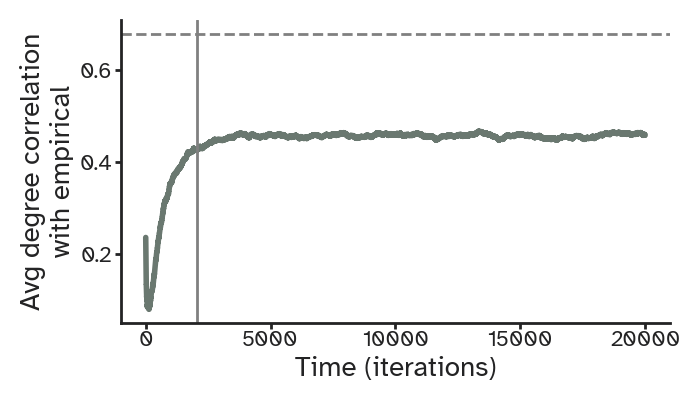

In [31]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(degree_correlation,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Avg degree correlation\nwith empirical")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
plt.axhline(np.mean(intersubject_correlation), color='gray', linestyle='--')

sns.despine()

Evaluating intersubject energy:   0%|          | 0/70 [00:00<?, ?it/s]

Evaluating intersubject energy: 100%|██████████| 70/70 [00:02<00:00, 24.05it/s]


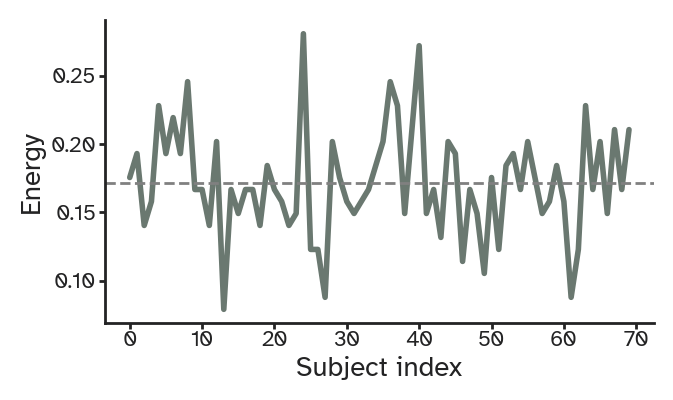

In [32]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
intersubject_energy = np.zeros(all_connectomes.shape[2])
for i in tqdm(range(all_connectomes.shape[2]), desc="Evaluating intersubject energy"):
    intersubject_energy[i] = evaluator(all_connectomes[:,:,i], connectivity, euclidean_dis)
plt.plot(intersubject_energy,lw=2)
plt.axhline(np.mean(intersubject_energy), color='gray', linestyle='--')
plt.xlabel("Subject index")
plt.ylabel("Energy")
sns.despine()

In [42]:
from numba import njit, prange

@njit
def rank_data(x):
    """
    Returns the rank of each element in x.
    Ties are assigned distinct ranks in ascending order (i.e. no tie-averaging).
    For exact Spearman with tie correction, you'd need a more elaborate approach.
    """
    # argsort gives sorted indices of x
    sorted_idx = np.argsort(x)
    ranks = np.empty_like(sorted_idx, dtype=np.float64)
    
    # assign ranks in ascending order
    rank = 1.0
    for idx in sorted_idx:
        ranks[idx] = rank
        rank += 1.0
        
    return ranks

@njit
def pearson_corr(x, y):
    """
    Compute Pearson correlation for two 1D arrays of same length.
    (Assumes no NaNs. If you have missing data, you need additional checks.)
    """
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Compute numerator and denominators
    num = 0.0
    den_x = 0.0
    den_y = 0.0
    
    for i in range(x.shape[0]):
        dx = x[i] - mean_x
        dy = y[i] - mean_y
        num  += dx * dy
        den_x += dx * dx
        den_y += dy * dy
    
    return num / np.sqrt(den_x * den_y)

@njit(parallel=True)
def compute_spearman_rowwise(adjacency_history, all_connectomes):
    """
    adjacency_history: shape (n_rows, n_features, n_timepoints)
    all_connectomes:   shape (n_rows, n_features, n_subjects)
    
    Returns
    -------
    correlation_matrix: shape (n_timepoints, n_subjects)
        Each entry is the average row-wise Spearman correlation between 
        adjacency_history[:, :, t] and all_connectomes[:, :, s].
    """
    
    n_rows = adjacency_history.shape[0]
    n_timepoints = adjacency_history.shape[2]
    n_subjects = all_connectomes.shape[2]
    
    correlation_matrix = np.empty((n_timepoints, n_subjects), dtype=np.float64)
    
    for t in prange(n_timepoints):        # parallel over timepoints
        for s in range(n_subjects):       # nested loop over subjects
            sum_corr = 0.0
            # Accumulate row-wise correlation for each i in [0..n_rows)
            for i in range(n_rows):
                # rank-transform each row
                x_rank = rank_data(adjacency_history[i, :, t])
                y_rank = rank_data(all_connectomes[i, :, s])
                
                # pearson_corr of the ranks
                r = pearson_corr(x_rank, y_rank)
                sum_corr += r
            
            # average over all rows
            correlation_matrix[t, s] = sum_corr / n_rows
    
    return correlation_matrix

# -- Usage --
# Let's say adjacency_history.shape = (N, P, T)
# and          all_connectomes.shape = (N, P, S)
correlation_matrix = compute_spearman_rowwise(adjacency_history, all_connectomes)
print("Shape of correlation_matrix: ", correlation_matrix.shape)

Shape of correlation_matrix:  (3000, 70)


In [191]:
## Too slow
# correlation_matrix = np.zeros((adjacency_history.shape[2], all_connectomes.shape[2]))

# for t in tqdm(range(adjacency_history.shape[2]), desc="Computing correlations"):
#     for s in range(all_connectomes.shape[2]):
#         row_correlations = np.array([spearmanr(adjacency_history[i,:,t], all_connectomes[i,:,s])[0] 
#                                    for i in range(adjacency_history.shape[0])])
#         correlation_matrix[t,s] = np.nanmean(row_correlations)

/var/folders/jj/cg03q6f13lb9h32fwmdrmzrm0000gp/T/ipykernel_10228/3567049667.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


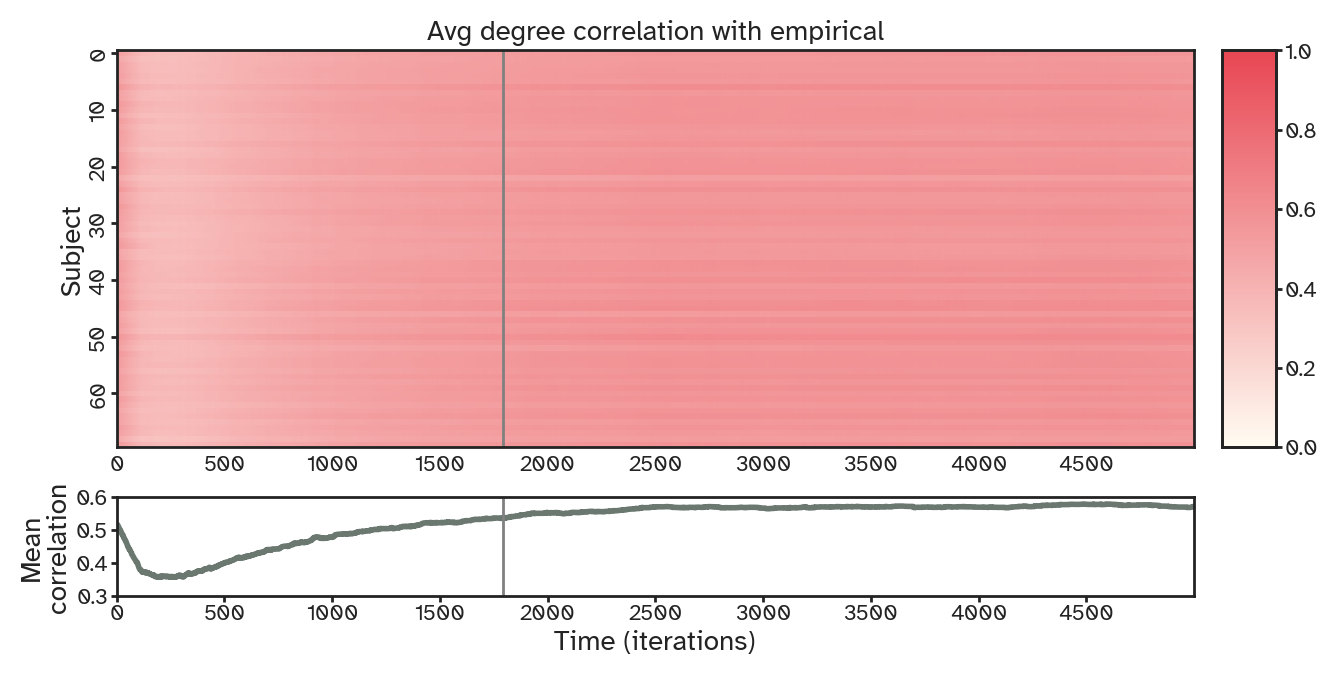

In [193]:
# Calculate mean correlation across subjects for each timepoint
mean_correlation = np.nanmean(correlation_matrix, axis=1)

fig = plt.figure(figsize=viz.cm_to_inch((19,9)), dpi=200)
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1], width_ratios=[20, 1], hspace=0.2, wspace=0.05)

# Top subplot (heatmap)
ax_heatmap = fig.add_subplot(gs[0, 0])
im = sns.heatmap(correlation_matrix.T, 
                 cmap=default_cmaps['bw_lr'],
                 vmax=1, vmin=0,
                 yticklabels=10, 
                 xticklabels=500,
                 ax=ax_heatmap,
                 cbar=False)
ax_heatmap.set_ylabel("Subject")
ax_heatmap.set_title("Avg degree correlation with empirical")
ax_heatmap.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
# Colorbar as extension of the heatmap
cbar_ax = fig.add_subplot(gs[0, 1])
plt.colorbar(im.collections[0], cax=cbar_ax)

# Bottom subplot (mean correlation)
ax_line = fig.add_subplot(gs[1, 0], sharex=ax_heatmap)
ax_line.plot(mean_correlation, lw=2,)
ax_line.set_xlabel("Time (iterations)")
ax_line.set_ylabel("Mean\ncorrelation")
ax_line.axhline(0, color="gray", linestyle="--")
ax_line.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
ax_line.set_ylim(0.3, 0.6)
# Align x-axes and tidy up
ax_heatmap.tick_params(axis='x', which='both', bottom=False)
sns.despine(fig=fig, top=False, right=False)
plt.tight_layout()

In [189]:
max_indices = np.unravel_index(np.nanargmax(correlation_matrix), correlation_matrix.shape)
print(f"Maximum correlation found at time step {max_indices[0]} and subject {max_indices[1]}")
print(f"Maximum correlation value: {correlation_matrix[max_indices]}")

Maximum correlation found at time step 4326 and subject 50
Maximum correlation value: 0.6291266937315545


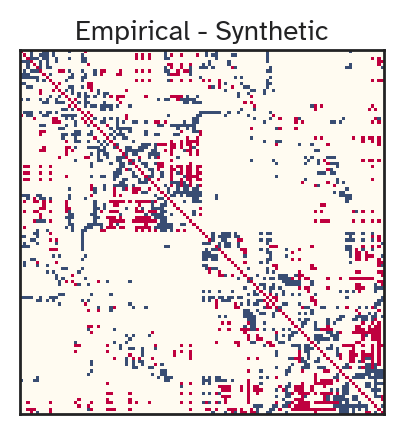

In [190]:
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(all_connectomes[:,:,50]-adjacency_history[:,:,4326], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [35]:
from navigation_game import ParameterSpace, NetworkFitter, SimulationMode

param_space = ParameterSpace(
    param_ranges={
        'alpha': (100.0, 200.0),
        'beta': (0.01, 1),
    },
    fixed_params={
        'connectivity_penalty': 0.0,
        'temperature': 0.0,
    }
)

fitter = NetworkFitter(
    coordinates=coordinates,
    empirical_adj=connectivity,
    parameter_space=param_space,
    mode=SimulationMode.FIXED,
    n_trials=120,
    n_iterations=2500,
)

results = fitter.fit()

Simulating network evolution:   0%|          | 12/2499 [00:00<01:42, 24.20it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Simulating network evolution:  96%|█████████▌| 2393/2499 [01:37<00:04, 24.51it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Simulating network evolution:   8%|▊         | 191/2499 [00:07<01:34, 24.31it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/jo

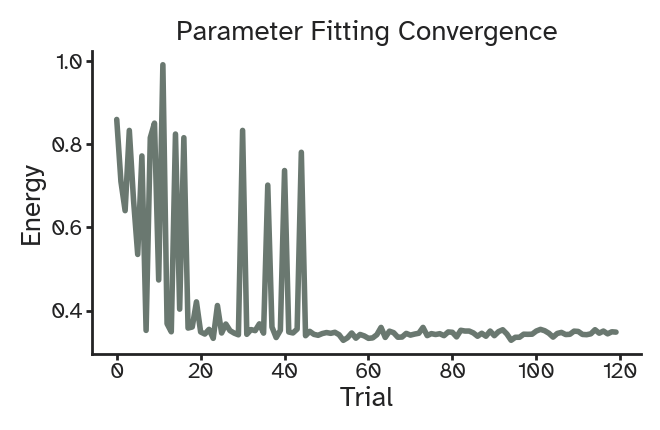

In [36]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(results.all_scores,lw=2)
plt.xlabel('Trial')
plt.ylabel('Energy')
plt.title('Parameter Fitting Convergence')
sns.despine()

In [37]:
results.best_params

{'alpha': 157.6577133912889,
 'beta': 0.14643042370648765,
 'connectivity_penalty': 0.0,
 'temperature': 0.0}

In [38]:
results.best_score

0.3285381187844794

Evaluating network evolution: 100%|██████████| 3000/3000 [02:14<00:00, 22.26it/s]


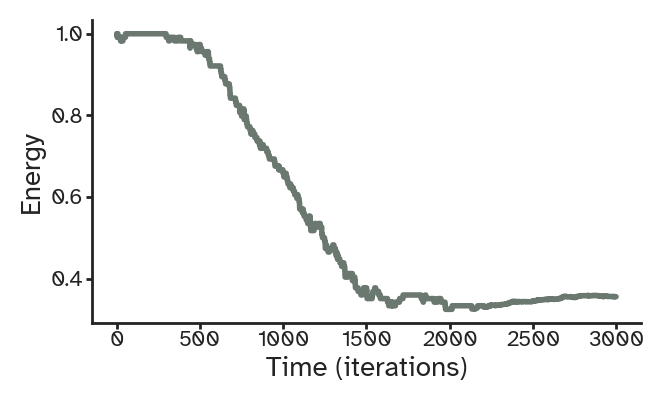

In [39]:
fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=results.best_params['alpha'],
    beta=results.best_params['beta'],
    temperature=0.0,
    connectivity_penalty=0.0
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=3_000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
sns.despine()

<Axes: >

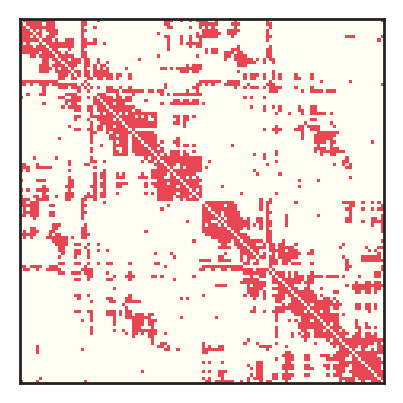

In [40]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(best_fit_matrix, sns_kwargs={"cmap":default_cmaps["bw_lr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)


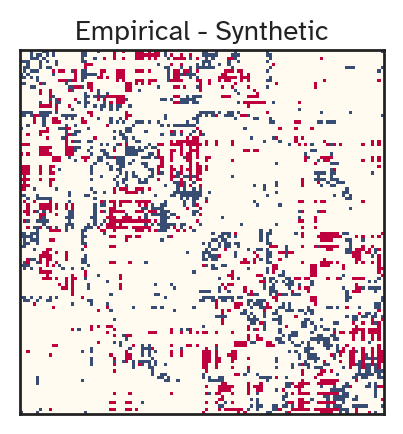

In [41]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy.typing import NDArray
from typing import Optional

def animate_network_evolution(coordinates: NDArray[np.float64], 
                            adjacency_history: NDArray[np.int8],
                            interval: int = 50,
                            save_path: Optional[str] = None) -> FuncAnimation:
    """
    Create an animation of network evolution over time.
    
    Args:
        coordinates: Array of shape (n_nodes, 2) containing node coordinates
        adjacency_history: Array of shape (n_nodes, n_nodes, n_timesteps) 
                         containing adjacency matrices at each timestep
        interval: Time between frames in milliseconds
        save_path: Optional path to save animation (e.g., "animation.gif")
    
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Setup the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    
    # Create networkx graph
    G = nx.Graph()
    G.add_nodes_from(range(len(coordinates)))
    pos = {i: coordinates[i] for i in range(len(coordinates))}
    
    # Initialize plot elements
    node_collection = nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                           node_size=300, ax=ax)
    edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                       fontsize=12, ha='left', va='top')
    
    # Set animation properties
    node_collection.set_animated(True)
    time_text.set_animated(True)
    
    def update(frame):
        """Update animation for each frame"""
        # Clear current edges
        if len(ax.collections) > 1:
            ax.collections[1].remove()
        
        # Get current adjacency matrix
        adj = adjacency_history[:, :, frame]
        
        # Update edges
        edge_list = [(i, j) for i in range(len(adj)) 
                    for j in range(i+1, len(adj)) if adj[i,j]]
        G.clear_edges()
        G.add_edges_from(edge_list)
        
        # Draw new edges
        edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
        
        # Update timestep text
        time_text.set_text(f'Timestep: {frame}')
        
        return node_collection, edge_collection, time_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=adjacency_history.shape[2],
                        interval=interval)
    
    # Save if path provided
    if save_path:
        anim.save(save_path, writer='pillow')
    
    plt.close()
    return anim

In [63]:
anim = animate_network_evolution(coordinates[:, :2], adjacency_history[:,:,::10], save_path='network_evolution.gif')